In [6]:
# all pacakges needed to run this code
import scipy
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg 
from scipy import linalg
import igraph as ig
from igraph import Graph
from sklearn.preprocessing import normalize

In [7]:
def HittingTimes_L3(M):
    #Requires a stochastic matrix and outputs a matrix of probabilities of 
    # leaving i and then hitting j before returning back to i 
    N = M.shape[0]
    e1 = np.zeros((1, N))
    e1[0,0] = 1
    a1inv = np.eye(N) - M
    a1inv[0,] = e1
    a1inv = np.linalg.inv(a1inv)
    Q = np.zeros((N, N))
    Q[:, 0] = np.divide(a1inv[:, 0], np.diag(a1inv))
    M = M @ a1inv
    
    detcj = (1 + np.diag(M)) * (1 - M[0, 0]) + M[:, 0] * np.transpose(M[0,])
    cjinv = np.zeros((2, 2, N))
    cjinv[0, 0, :] = (1 - M[0, 0]) / detcj
    cjinv[0, 1, :] = M[:, 0] / detcj
    cjinv[1, 0, :] = -(np.transpose(M[0,])) / detcj
    cjinv[1, 1, :] = (1 + np.diag(M)) / detcj
    
    M1 = np.double(np.zeros((N, 2, N)))
    M1[:, 0, :] = a1inv
    a = np.array(-a1inv[:, 0])
    a = a.reshape(N, 1)
    M1[:, 1, :] = np.tile(a, (1, N))
    M2 = np.zeros((2, N, N))
    M2[0, :, :] = np.transpose(M)
    M2[1, :, :] = np.transpose(np.tile(M[0,], (N, 1)))
    ac = np.zeros((N, 1))
    ad = np.zeros((N, 1))
    for j in range(1, N):
        
        ac = a1inv[:, j] - M1[..., j] @ cjinv[..., j] @ M2[:, j, j]
        st = np.transpose(M1[..., j]) * (cjinv[..., j] @ M2[..., j])
        ad = np.diag(a1inv) - np.transpose(st.sum(axis = 0))
        Q[:, j] = ac / ad
    Q = Q - np.diag(np.diag(Q))
    return Q

In [8]:
def get_Ahp(P, beta=0.5):
    # Find the invariant measure given the matrix of probabilities found in
    # HittingTimes_L3
    Q = HittingTimes_L3(P)
    n = P.shape[0]
    [w, v] = scipy.sparse.linalg.eigsh(np.double(np.transpose(P)), k=1, M=None, sigma=1+1e-6, which='LM', v0=np.ones(n), ncv=None, maxiter=100000, tol=1e-3, return_eigenvectors=True, Minv=None, OPinv=None, mode='normal')
    v = (np.absolute(v) / linalg.norm(v, 1))
    vt = np.transpose(v)
    
    #Constructs the symmetric adjacenncy matrix M
    if beta == 0.5:
        Aht = scipy.sparse.spdiags(vt ** 0.5, diags=0, m=n, n=n) @ Q @ scipy.sparse.spdiags(vt ** (-0.5), diags=0, m=n, n=n)
    elif beta == 1:
        v_arr = v.flatten(order="F")
        v_diag = np.diag(v_arr)
        Aht = v_diag @ Q
        
    Aht = 0.5 * (Aht + np.transpose(Aht))
    Aht = Aht - np.diag(np.diag(Aht))
    return Aht

In [9]:
def extEffRes(A):
    # the input A is the probability transition matrix for a (possibly)
    # directed graph
    # this function outputs the extended effective resistance as defined
    # in Young, Scardovi, and Leonard (2013). The notation below is from
    # this paper
    # R itself is not a metric, we will want to use R^0.5
    n = A.shape[0]
    d_out = A.sum(axis=1)
    L = np.diag(d_out) - A
    Pi = np.eye(n) - ((1 / (n)) * np.ones(n))
    D, V = scipy.linalg.eigh(Pi)
    Q = np.transpose(V[:, 1:])
    rL = Q @ L @ np.transpose(Q)
    Sig = linalg.solve_continuous_lyapunov(rL, np.eye(n - 1))
    X = 2 * (np.transpose(Q) @ Sig @ Q)
    R = np.zeros((n, n))
    for ii in range(0, n):
        for jj in range(ii, n):
            r = X[ii, ii] + X[jj, jj] - 2 * X[ii, jj]
            R[ii, jj] = r
            R[jj, ii] = r
    return R 

In [18]:

# create a graph with two cycles glued along a path
tt = 60 # numpber of vertices in each cycle
m = 5 # number of shared vertices
n = 2 * tt - m # total number of vertices
P = np.zeros((n, n))

#fill first cycle
for ii in range(0, tt-1):
    P[ii, ii + 1] = 1

# last vertex in the first cycle splits
P[tt - 1, 0] = 0.5
P[tt - 1, tt] = 0.5

# second cycle
for ii in range(tt, n - 1):
    P[ii, ii + 1] = 1
    
# last vertex of second cycle joins back to the tt-m+1 vertex
P[n - 1, tt - m] = 1

#make this matrix into a graph to better visualize the network
pgraph = Graph.Adjacency(P, mode="directed")

# compute extended effective resistance on P
R = extEffRes(P)   
R = np.sqrt(R)

# compute the hitting probability matrix when beta=1/2
d12 = -np.log(get_Ahp(P))
for i in range(0, n):
    d12[i, i] = 0

# compute the hitting probability matrix when beta=1
d1 = -np.log(get_Ahp(P, 1))
for i in range(0, n):
    d1[i, i] = 0
assert (np.nanmax(((d1 - np.transpose(d1)) / d1)) < 0.001)
r = np.rint((tt - m) / 2)

# create an undirected tree graph as another geeometric set example
tgraph = Graph.Tree(115,5)
tmat = np.array(tgraph.get_adjacency().data)
#normalize the data so that the rows each sum to 1; need to do this to 
# correctly compute the Hitting Probability matrices and extended effective
# resistance
tmat = normalize(tmat, axis=1, norm='l1')

# compute extended effective resistance on the tree graph
R = extEffRes(tmat)   
R = np.sqrt(R)

# compute the hitting probability matrix when beta=1/2
dt_12 = -np.log(get_Ahp(tmat))
for i in range(0, 60):
    dt_12[i, i] = 0
    
# compute the hitting probability matrix when beta=1
dt_1 = -np.log(get_Ahp(tmat, 1))
for i in range(0, 60):
    dt_1[i, i] = 0
assert (np.nanmax(((dt_1 - np.transpose(dt_1)) / dt_1)) < 0.001)

C:\Users\Maddy\AppData\Local\Temp\ipykernel_17576\2562672084.py:30: RuntimeWarning: divide by zero encountered in log
  d12 = -np.log(get_Ahp(P))
C:\Users\Maddy\AppData\Local\Temp\ipykernel_17576\2562672084.py:35: RuntimeWarning: divide by zero encountered in log
  d1 = -np.log(get_Ahp(P, 1))
C:\Users\Maddy\AppData\Local\Temp\ipykernel_17576\2562672084.py:38: RuntimeWarning: invalid value encountered in divide
  assert (np.nanmax(((d1 - np.transpose(d1)) / d1)) < 0.001)
C:\Users\Maddy\AppData\Local\Temp\ipykernel_17576\2562672084.py:54: RuntimeWarning: divide by zero encountered in log
  dt_12 = -np.log(get_Ahp(tmat))
C:\Users\Maddy\AppData\Local\Temp\ipykernel_17576\2562672084.py:59: RuntimeWarning: divide by zero encountered in log
  dt_1 = -np.log(get_Ahp(tmat, 1))
C:\Users\Maddy\AppData\Local\Temp\ipykernel_17576\2562672084.py:62: RuntimeWarning: invalid value encountered in subtract
  assert (np.nanmax(((dt_1 - np.transpose(dt_1)) / dt_1)) < 0.001)
C:\Users\Maddy\AppData\Local\Tem

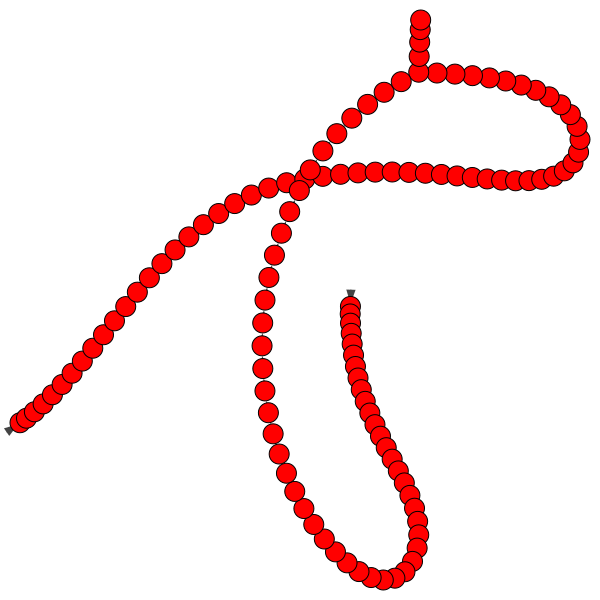

In [15]:
ig.plot(pgraph, layout="fruchterman_reingold")
#the nodes aren't reconnecting to form two cycles... WHY

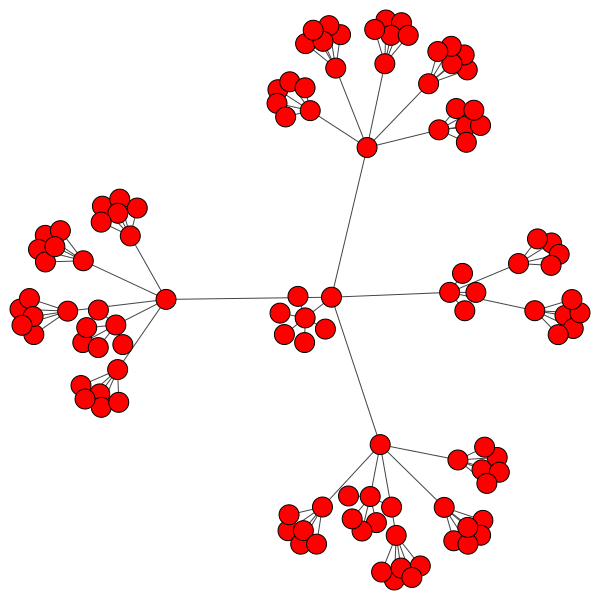

In [19]:
ig.plot(tgraph)